In [104]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import numpy as np

# data_folder = "pilot_data"
data_folder = "experiment_data"

data_csvs = ["stress-performance_all_tidy.csv", "stress-performance6_all_tidy.csv", "stress-performance7_all_tidy.csv",
             "stress-performance8_all_tidy.csv", "stress-performance9_all_tidy.csv"]
data_dfs = []

with open("trial_mapping_with_solutions_balanced.json", "r", encoding="utf-8") as f:
    stimuli_map = json.load(f)

for csv_file in data_csvs:

    df = pd.read_csv(f"{data_folder}\\{csv_file}")

    df = df.drop(columns=["rejectReason", "rejectTime", "configHash", "responseMin", "responseMax"])

    df = df.dropna(subset=["trialOrder"]).reset_index(drop=True)

    df['percentComplete'] = df['percentComplete'].astype(float)

    dfs_by_participant = {
        pid: subdf
        for pid, subdf in df.groupby("participantId")
        if subdf['percentComplete'].eq(100).all()
        # if subdf['status'].eq('completed').all()
    }


    def get_prolific_id(df_pid):
        mask = df_pid['trialId'].str.contains('prolific', na=False)
        if not df_pid.loc[mask].empty:
            return df_pid.loc[mask, 'answer'].iloc[0]
        return None

    blacklist = ["jacob", "test", "test-index6", "test-index7", "test-index8", "test-index9"]
    pilot_with_bad_stimuli = ['6606d4f4acdc3a6b8200c0ee', '573c6b96b3a71f00146df8c4', '67c60d4d83aab66707607562', '67e977ee281a53f16a11f194', '60e0dc6be0772b7dfdad9b2c', '559272f4fdf99b7e42e96932', '655a7071a83469926d8291b3', '6717c466a1a5d0cb15bca12e', '63d05dfdf2faf2f6c3910784', '6393a3235edc1cd2ebfcb3db', '680c9ce28ed46a864a300a0a', '5c643f1140c2610001424b7f', '67d43f5c7253c147df75e9e5', '5e6a923f59a3bd04d5edc606', '6060fb525f262e237d167361']
    blacklist.extend(pilot_with_bad_stimuli)
    dfs_by_participant = {
        pid: subdf
        for pid, subdf in dfs_by_participant.items()
        if get_prolific_id(subdf) not in blacklist
    }

    drop_orders = [1,2,3,4,5,6,7,8,9,10,11,12,13,23,24,25,35,36,37]

    dfs_by_participant = {
        pid: subdf[~subdf['trialOrder'].isin(drop_orders)].reset_index(drop=True)
        for pid, subdf in dfs_by_participant.items()
    }

    for pid, subdf in dfs_by_participant.items():
        subdf['answer'] = subdf['answer'].replace("I am unable to work this out", 0)

        def extract_ksm(s):
            m = re.search(r'-([0-9]+(?:\.[0-9]+)?)\.png$', s)
            if not m:
                return None
            return float(m.group(1))

        def lookup_correct(indices):
            if indices == "undefined":
                return None

            i1, i2, i3 = str(indices).split(',')
            return stimuli_map[i1][i2][int(i3)][1]

        def lookup_graph(indices):
            if indices == "undefined":
                return None

            i1, i2, i3 = str(indices).split(',')
            return stimuli_map[i1][i2][int(i3)][0]
        
        def extract_graph_size(indices):
            if indices == "undefined":
                return None

            i1, i2, i3 = str(indices).split(',')

            return int(i2)

        def lookup_ksm(indices):
            if indices == "undefined":
                return None

            i1, i2, i3 = str(indices).split(',')

            image_Str = stimuli_map[i1][i2][int(i3)][0]
            return extract_ksm(image_Str)
        
        def extract_graph_id(fname):
            if not fname:
                return None
            # matches “-<graphNum><Variant>-drawing” e.g. “-2B-drawing”
            m = re.search(r'-(\d+)([A-C])\-drawing', fname)
            if m:
                num, var = m.groups()
                return f"g{num}_{var.lower()}"
            return None


        

        subdf['correctAnswer'] = subdf['parameters_indices'].apply(lookup_correct)
        subdf['graph_fname'] = subdf['parameters_indices'].apply(lookup_graph)
        subdf['ksm_value'] = subdf['parameters_indices'].apply(lookup_ksm)
        subdf['graph_size'] = subdf['parameters_indices'].apply(extract_graph_size)
        subdf['graph_id'] = subdf['graph_fname'].apply(extract_graph_id)


        mask = subdf['parameters_indices'] != "undefined"
        subdf['accuracy'] = pd.NA
        subdf.loc[mask, 'accuracy'] = (
            (subdf.loc[mask, 'answer'].astype(int) == subdf.loc[mask, 'correctAnswer'].astype(int))
            .astype(int)
        )

    # print(len(dfs_by_participant))
    for k, v in dfs_by_participant.items():
        # print(get_prolific_id(v))
        pass

        # v.to_csv(f"{k}.csv", index=False)
    if dfs_by_participant:
        data_dfs.append(pd.concat(dfs_by_participant.values(), ignore_index=True))
    # all_df = pd.concat(dfs_by_participant.values(), ignore_index=True)
    # all_df['duration'] = pd.to_numeric(all_df['duration'], errors='coerce')


all_df = pd.concat(data_dfs, ignore_index=True)

all_df['duration'] = pd.to_numeric(all_df['duration'], errors='coerce') / 1000 # in seconds


def get_prolific_ids(df_pid):
    mask = df_pid['trialId'].str.contains('prolific', na=False)
    if not df_pid.loc[mask].empty:
        return df_pid.loc[mask, 'answer']
    return None

prolific_ids = get_prolific_ids(all_df)
print(len(prolific_ids))
for v in prolific_ids:
    print(v)



# all_df.to_csv("cleaned.csv")

# print(len(all_df))

    

36
57c357770e6a1f00015f6038
63d79bf2271aa409e093e403
67d00ceb0de1512e5669d4c5
66e48a2f722b573550b3796f
59b7cbab110131000146620b
67d2f0a3fc7591bc603ac592
6718b63a1e293387ef30d259
5c8cfc3772503f0001e9c965
650bf1ac0d10133573ffdae6
604541676af7216614098dde
67eb09d69af29d8b61649c0d
665585d3c2b72eebdd366c8e
5c0873675b32d500012e3f2c
676d2c3ddcb926c724d27928
64f3036a5b5f2feae0b1f51b
5ee4a14b578f8a000b384376
628556bcf5ea3ef851de9fed
67e7cdfb2d3c81d83ccef700
5bed755fcca71f00014111e6
655371cac562a3701896f9fc
66d9cd06e207a93377f7820e
5ef877bb6b0ed15b3f6ae106
6570824312e21ad0a49858f4
6772635d620fb499e8d268e6
60417f7d70c41216d2b26c13
666ee5994b49ad9236867a62
598c4b28cceb0f0001b39675
5b8bf5dd7b334200011da4aa
68236d1744d33c89ca2913b2
6731413b949994960fadc176
65b40d86a6572ea6620e8c3d
66c19251237692d2ae3bb12f
64e9ceb64f65c6acfb677504
65a5decb6545ad77deeaf1cb
67486ef5b88595ed8d20fe7c
665e2e4ec1e8281198d5f8d5


In [105]:
# filtering

# all trials where duration > 60s
# all_df = all_df[all_df['duration'] <= 60].reset_index(drop=True)

# drop one outlier
all_df = all_df[all_df['duration'] <= 500].reset_index(drop=True)

# all trials where spl == 2
# all_df = all_df[all_df['correctAnswer'] != 2].reset_index(drop=True)

# all trials where they asnwered "I am unable to work this out"
# all_df = all_df[all_df['answer'] != 0].reset_index(drop=True)

<Figure size 800x600 with 0 Axes>

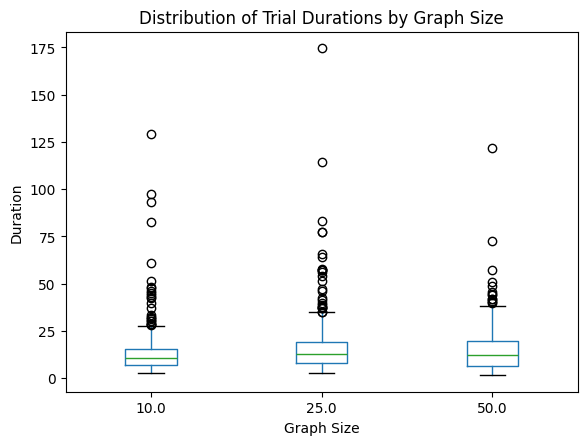

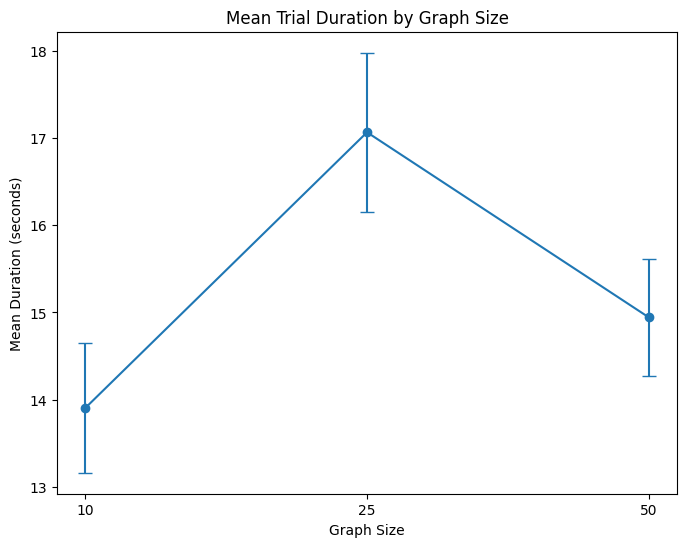

In [106]:
# Trial durations

plot_df = all_df.dropna(subset=['graph_size', 'duration'])

# box plots
plt.figure(figsize=(8, 6))
plot_df.boxplot(column='duration', by='graph_size', grid=False)

plt.xlabel('Graph Size')
plt.ylabel('Duration')
plt.title('Distribution of Trial Durations by Graph Size')
plt.suptitle('')
plt.show()

# Line chart
summary = (
    plot_df
    .groupby('graph_size')['duration']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# categorical x-axis
categories = summary['graph_size'].astype(int).astype(str).tolist() 
x_positions = range(len(categories))


fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)

ax.set_xticks(x_positions)
ax.set_xticklabels(categories)

ax.set_xlabel('Graph Size')
ax.set_ylabel('Mean Duration (seconds)')
ax.set_title('Mean Trial Duration by Graph Size')
plt.show()


<Figure size 800x600 with 0 Axes>

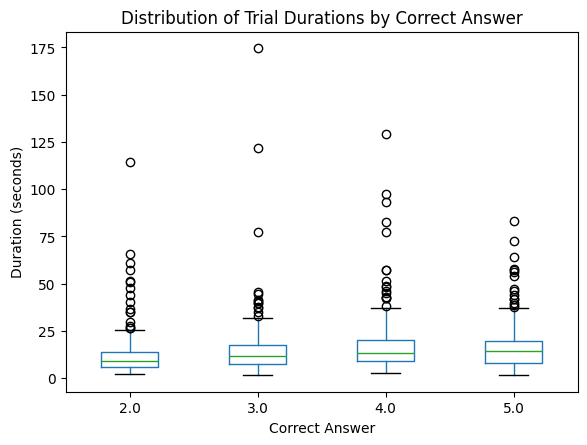

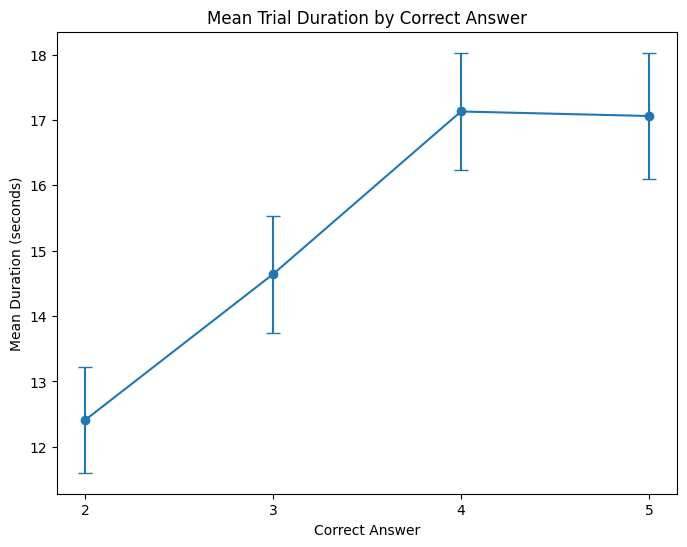

In [107]:
# Duration vs spl

plot_df = all_df.dropna(subset=['correctAnswer','duration'])

# boxplot
plt.figure(figsize=(8,6))
plot_df.boxplot(column='duration', by='correctAnswer', grid=False)
plt.xlabel('Correct Answer')
plt.ylabel('Duration (seconds)')
plt.title('Distribution of Trial Durations by Correct Answer')
plt.suptitle('')  # remove the auto‐subtitle
plt.show()

# Line chart
summary = (
    plot_df
    .groupby('correctAnswer')['duration']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# categorical x-axis
categories = summary['correctAnswer'].astype(int).astype(str).tolist()
x_positions = range(len(categories))

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)

ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_xlabel('Correct Answer')
ax.set_ylabel('Mean Duration (seconds)')
ax.set_title('Mean Trial Duration by Correct Answer')
plt.show()

<Figure size 800x600 with 0 Axes>

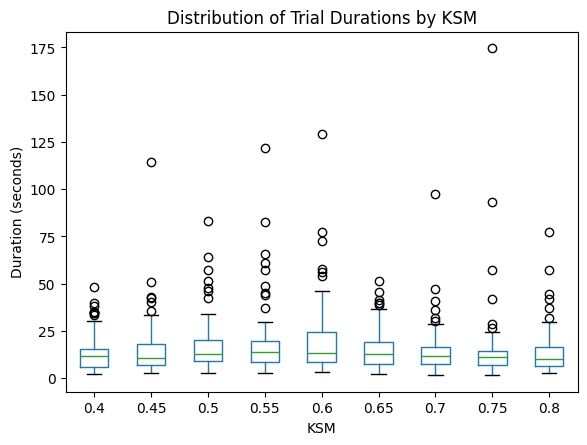

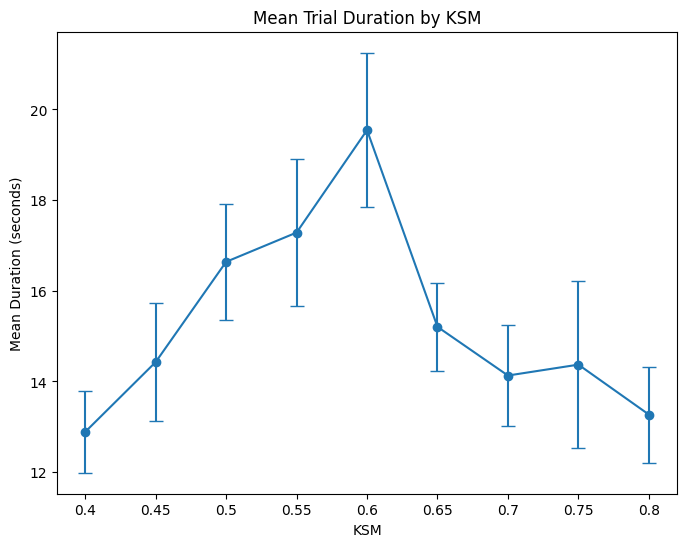

In [108]:
# Duration vs ksm

plot_df = all_df.dropna(subset=['ksm_value','duration'])

# boxplot
plt.figure(figsize=(8,6))
plot_df.boxplot(column='duration', by='ksm_value', grid=False)
plt.xlabel('KSM')
plt.ylabel('Duration (seconds)')
plt.title('Distribution of Trial Durations by KSM')
plt.suptitle('') 
plt.show()

# Line chart
summary = (
    plot_df
    .groupby('ksm_value')['duration']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# categorical x-axis
categories = summary['ksm_value'].astype(str).tolist()
x_positions = range(len(categories))

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)

ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_xlabel('KSM')
ax.set_ylabel('Mean Duration (seconds)')
ax.set_title('Mean Trial Duration by KSM')
plt.show()

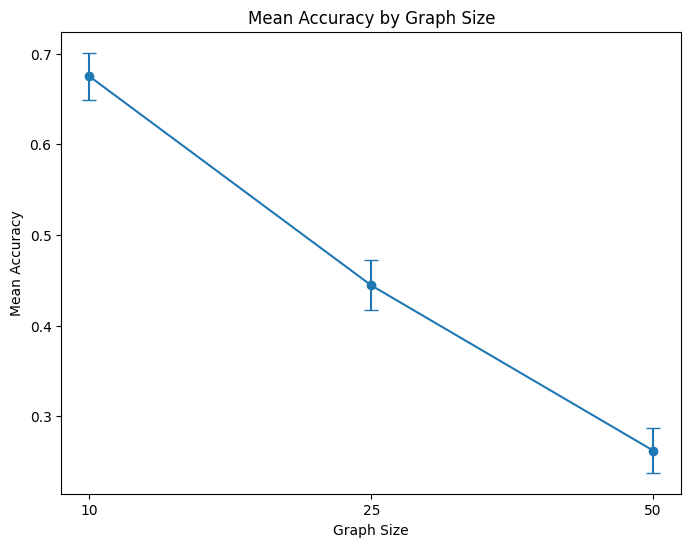

In [109]:
# Accuracy vs size

plot_df = all_df.dropna(subset=['graph_size','accuracy'])

# Line chart
summary = (
    plot_df
    .groupby('graph_size')['accuracy']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

categories = summary['graph_size'].astype(int).astype(str).tolist()
x_positions = range(len(categories))

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_xlabel('Graph Size')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by Graph Size')
plt.show()


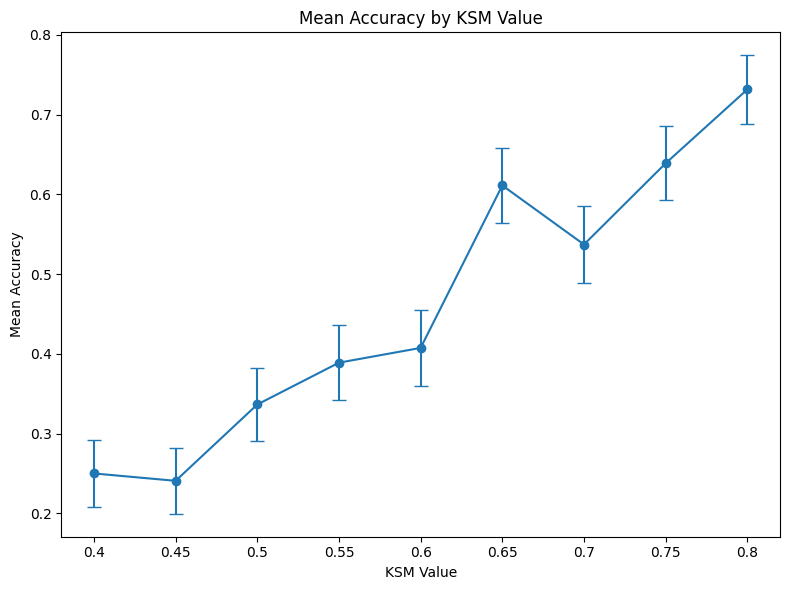

In [110]:

plot_df = all_df.dropna(subset=['ksm_value','accuracy'])


# line chart
summary = (
    plot_df
    .groupby('ksm_value')['accuracy']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

categories = summary['ksm_value'].astype(str).tolist()
x_positions = range(len(categories))

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_xlabel('KSM Value')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by KSM Value')
plt.tight_layout()
plt.show()


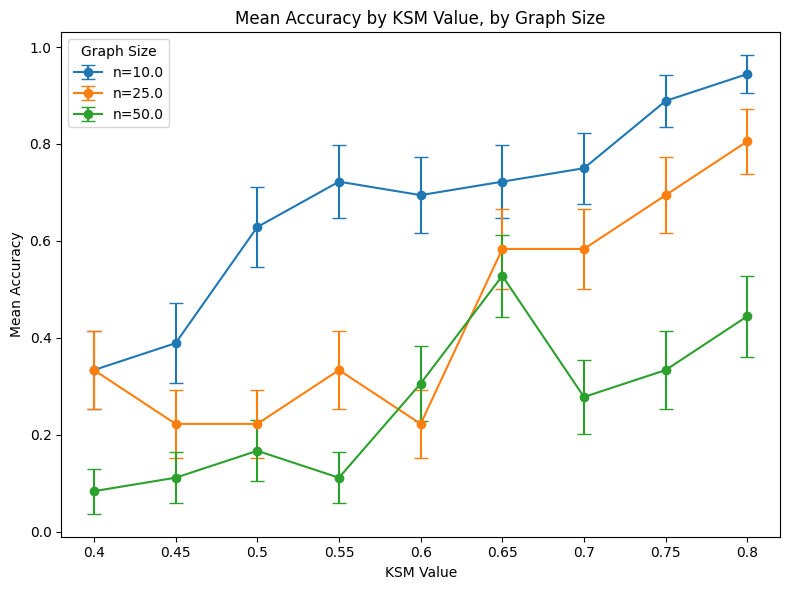

In [111]:


plot_df = all_df.dropna(subset=['ksm_value','graph_size','accuracy'])


summary = (
    plot_df
    .groupby(['graph_size','ksm_value'])['accuracy']
    .agg(mean='mean', sem='sem')
    .reset_index()
)


ksm_categories = sorted(summary['ksm_value'].unique())
x_positions = range(len(ksm_categories))
ksm_labels = [str(k) for k in ksm_categories]

fig, ax = plt.subplots(figsize=(8,6))


for size in sorted(summary['graph_size'].unique()):
    df_size = summary[summary['graph_size'] == size].set_index('ksm_value').reindex(ksm_categories)
    ax.errorbar(
        x_positions,
        df_size['mean'],
        yerr=df_size['sem'],
        fmt='o-',
        capsize=5,
        label=f'n={size}'
    )

ax.set_xticks(x_positions)
ax.set_xticklabels(ksm_labels)
ax.set_xlabel('KSM Value')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by KSM Value, by Graph Size')
ax.legend(title='Graph Size')
plt.tight_layout()
plt.show()


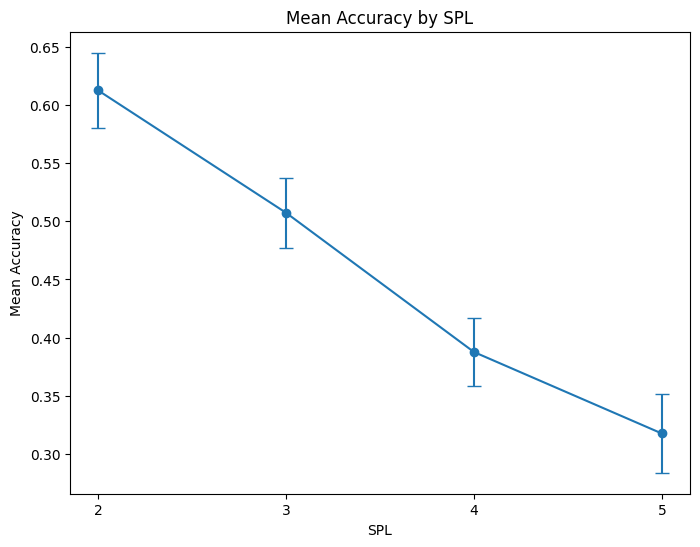

In [112]:

plot_df = all_df.dropna(subset=['correctAnswer','accuracy'])

# Line chart
summary = (
    plot_df
    .groupby('correctAnswer')['accuracy']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

categories = summary['correctAnswer'].astype(int).astype(str).tolist()
x_positions = range(len(categories))

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    x_positions,
    summary['mean'],
    yerr=summary['sem'],
    fmt='o-',
    capsize=5
)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_xlabel('SPL')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by SPL')
plt.show()


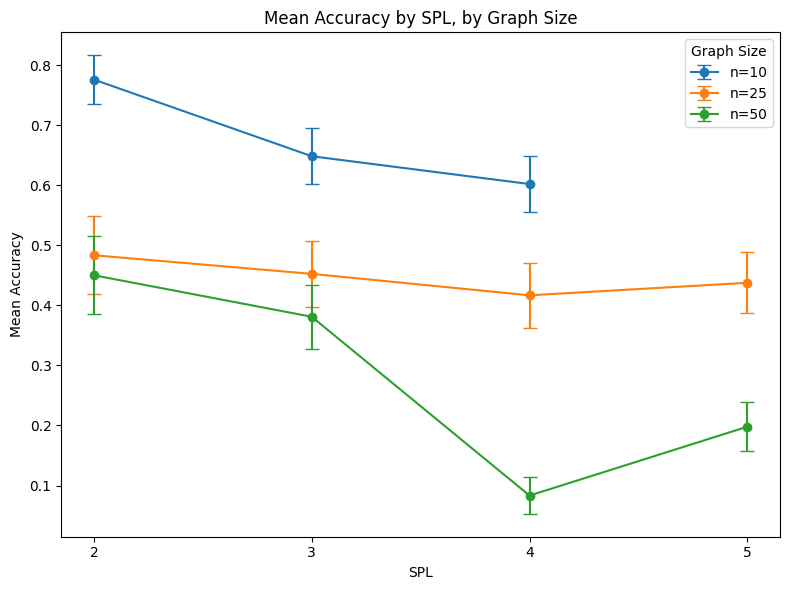

In [113]:
plot_df = all_df.dropna(subset=['graph_size','correctAnswer','accuracy'])


summary = (
    plot_df
    .groupby(['graph_size','correctAnswer'])['accuracy']
    .agg(mean='mean', sem='sem')
    .reset_index()
)


correct_cats = sorted(summary['correctAnswer'].unique())
x_positions = range(len(correct_cats))
x_labels = [str(int(c)) for c in correct_cats]

fig, ax = plt.subplots(figsize=(8,6))

for size in sorted(summary['graph_size'].unique()):
    df_size = (
        summary[summary['graph_size'] == size]
        .set_index('correctAnswer')
        .reindex(correct_cats)
    )
    ax.errorbar(
        x_positions,
        df_size['mean'],
        yerr=df_size['sem'],
        fmt='o-',
        capsize=5,
        label=f'n={int(size)}'
    )

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
ax.set_xlabel('SPL')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by SPL, by Graph Size')
ax.legend(title='Graph Size')
plt.tight_layout()
plt.show()

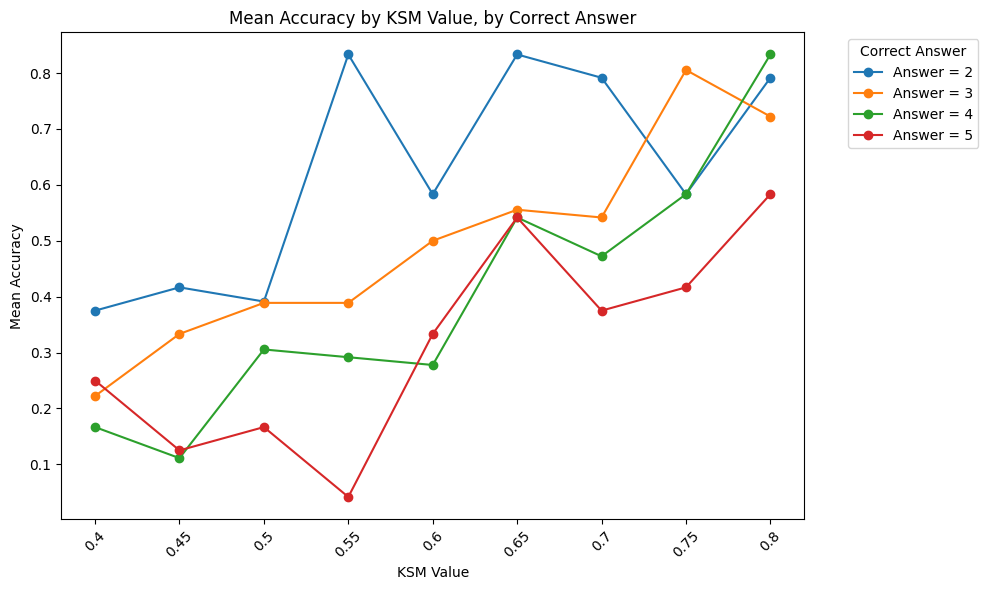

In [114]:
plot_df = all_df.dropna(subset=['ksm_value','correctAnswer','accuracy'])

summary = (
    plot_df
    .groupby(['ksm_value','correctAnswer'])['accuracy']
    .mean()
    .reset_index(name='mean')
)

ksm_cats = sorted(summary['ksm_value'].unique())
x_positions = range(len(ksm_cats))
x_labels = [str(k) for k in ksm_cats]

fig, ax = plt.subplots(figsize=(10,6))

for ans in sorted(summary['correctAnswer'].unique()):
    df_ans = (
        summary[summary['correctAnswer'] == ans]
        .set_index('ksm_value')
        .reindex(ksm_cats)
    )
    ax.plot(
        x_positions,
        df_ans['mean'],
        marker='o',
        linestyle='-',
        label=f'Answer = {int(ans)}'
    )

# formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45)
ax.set_xlabel('KSM Value')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy by KSM Value, by Correct Answer')
ax.legend(title='Correct Answer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


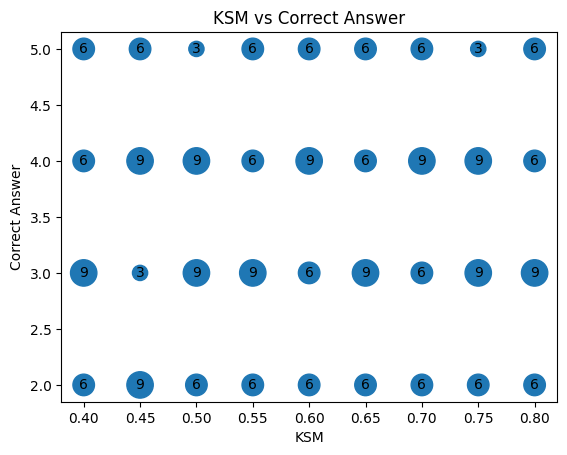

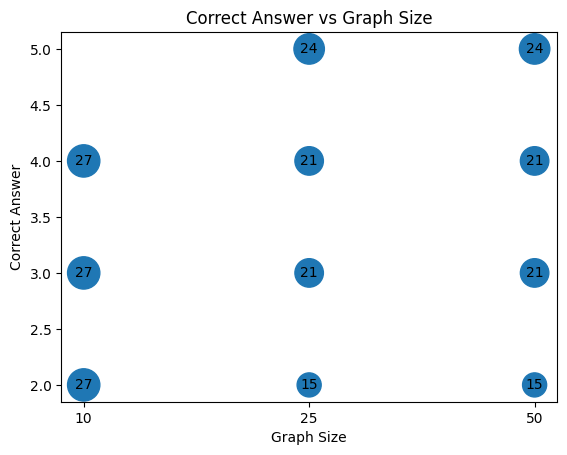

In [115]:
from collections import Counter

with open('trial_mapping_with_solutions_balanced.json', 'r', encoding='utf-8') as f:
    data = json.load(f)


ksm_vals = []
correct_answers = []

for participant_data in data.values():
    for size_trials in participant_data.values():
        for filename, answer in size_trials:
            match = re.search(r'-(\d\.\d+)\.png$', filename)
            if match:
                ksm_vals.append(float(match.group(1)))
                correct_answers.append(answer)


counts = Counter(zip(ksm_vals, correct_answers))

unique_points = list(counts.keys())
xs = [pt[0] for pt in unique_points]
ys = [pt[1] for pt in unique_points]
marker_sizes = [counts[p] * 40 for p in unique_points]  


plt.figure()
plt.scatter(xs, ys, s=marker_sizes)

for (x, y), count in counts.items():
    plt.text(x, y, str(count), ha='center', va='center')

plt.xlabel('KSM')
plt.ylabel('Correct Answer')
plt.title('KSM vs Correct Answer')
plt.show()


sizes = []
answers = []
for participant_data in data.values():
    for size_trials in participant_data.values():
        for filename, ans in size_trials:
            match = re.search(r'n(\d+)-', filename)
            if match:
                sizes.append(int(match.group(1)))
                answers.append(ans)


counts = Counter(zip(sizes, answers))

categories = sorted({size for size, _ in counts.keys()})          
cat_labels = [str(s) for s in categories]                        

unique_pairs = list(counts.keys())
ys = [pair[1] for pair in unique_pairs]
marker_sizes = [counts[p] * 20 for p in unique_pairs]

x_pos = [categories.index(pair[0]) for pair in unique_pairs]

plt.figure()
plt.scatter(x_pos, ys, s=marker_sizes)

for (size, answer), count in counts.items():
    idx = categories.index(size)
    plt.text(idx, answer, str(count), ha='center', va='center')


plt.xlabel('Graph Size')
plt.ylabel('Correct Answer')
plt.title('Correct Answer vs Graph Size')
plt.xticks(range(len(categories)), cat_labels)   
plt.show()

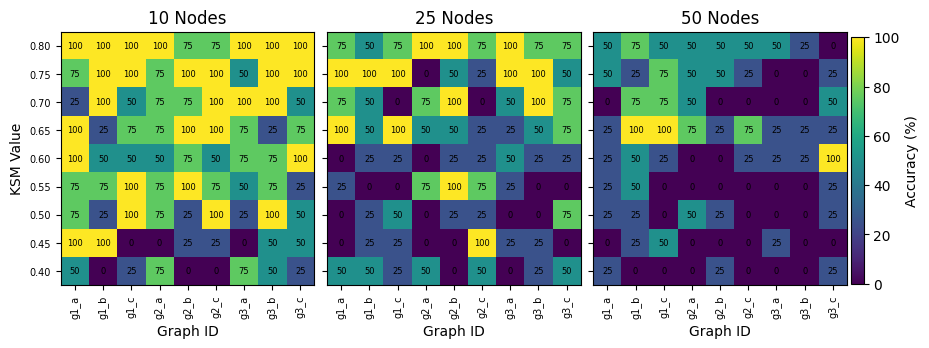

In [116]:

summary = (
    all_df
    .dropna(subset=['graph_size','graph_id','ksm_value','accuracy'])
    .groupby(['graph_size','graph_id','ksm_value'])['accuracy']
    .mean()
    .mul(100)
    .reset_index()
)


sizes     = sorted(summary['graph_size'].unique())
graph_ids = sorted(summary['graph_id'].unique(), key=lambda s:(int(s.split('_')[0][1:]), s))
ksm_vals  = sorted(summary['ksm_value'].unique())


fig, axes = plt.subplots(
    ncols=len(sizes),
    figsize=(12, 4),
    sharey=True
)

for ax, size in zip(axes, sizes):
    df_sz = summary[summary['graph_size'] == size]
    pivot = (
        df_sz
        .pivot(index='ksm_value', columns='graph_id', values='accuracy')
        .reindex(index=ksm_vals, columns=graph_ids)
    )
    mat = pivot.astype(float).values

    im = ax.imshow(
        mat,
        aspect='equal', 
        origin='lower',
        vmin=0, vmax=100
    )

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:.0f}", ha='center', va='center', fontsize=6)

    ax.set_title(f"{int(size)} Nodes")
    ax.set_xticks(np.arange(len(graph_ids)))
    ax.set_xticklabels(graph_ids, rotation=90, fontsize=7)
    ax.set_xlabel("Graph ID")
    if ax is axes[0]:
        ax.set_ylabel("KSM Value")
        ax.set_yticks(np.arange(len(ksm_vals)))
        ax.set_yticklabels([f"{k:.2f}" for k in ksm_vals], fontsize=7)


cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    orientation='vertical',
    shrink=0.8,
    pad=0.05     
)
cbar.set_label("Accuracy (%)")

plt.subplots_adjust(wspace=0.05, right=0.78, top=0.90, bottom=0.10)
plt.show()




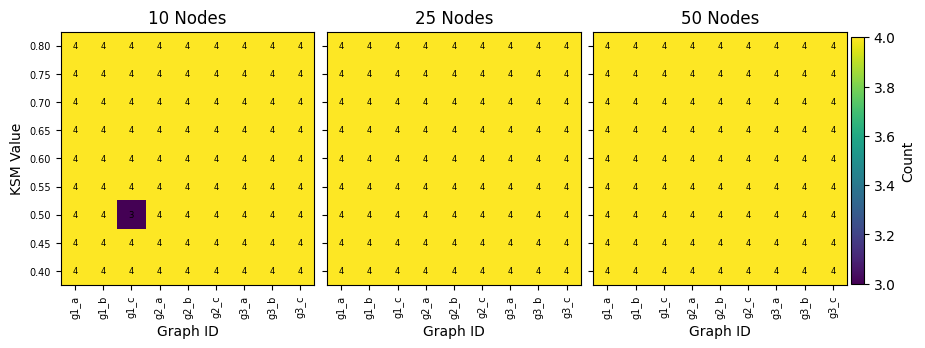

In [117]:


counts = (
    all_df
    .dropna(subset=['graph_size','graph_id','ksm_value'])
    .groupby(['graph_size','graph_id','ksm_value'])
    .size()
    .reset_index(name='count')
)

vmin = counts['count'].min()
vmax = counts['count'].max()
from matplotlib import colors
norm = colors.Normalize(vmin=vmin, vmax=vmax)


sizes = sorted(counts['graph_size'].unique())
graph_ids = sorted(counts['graph_id'].unique(), key=lambda s:(int(s.split('_')[0][1:]), s))
ksm_vals = sorted(counts['ksm_value'].unique())


fig, axes = plt.subplots(
    ncols=len(sizes),
    figsize=(12, 4),
    sharey=True
)

for ax, size in zip(axes, sizes):
    df_sz = counts[counts['graph_size'] == size]
    pivot = (
        df_sz
        .pivot(index='ksm_value', columns='graph_id', values='count')
        .reindex(index=ksm_vals, columns=graph_ids)
        .fillna(0)
    )
    mat = pivot.astype(int).values

    im = ax.imshow(
        mat,
        aspect='equal',    
        origin='lower',
        cmap='viridis',
        norm=norm
    )


    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]}", ha='center', va='center', fontsize=6)

    ax.set_title(f"{int(size)} Nodes")
    ax.set_xticks(np.arange(len(graph_ids)))
    ax.set_xticklabels(graph_ids, rotation=90, fontsize=7)
    ax.set_xlabel("Graph ID")
    if ax is axes[0]:
        ax.set_ylabel("KSM Value")
        ax.set_yticks(np.arange(len(ksm_vals)))
        ax.set_yticklabels([f"{k:.2f}" for k in ksm_vals], fontsize=7)


cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    orientation='vertical',
    shrink=0.8,
    pad=0.05
)
cbar.set_label("Count")


plt.subplots_adjust(wspace=0.05, right=0.78, top=0.90, bottom=0.10)
plt.show()


In [118]:

# needs updating, but not needed now that stimuli have same # of responses
part_idx = {}
for pid, subdf in dfs_by_participant.items():
    idxs = subdf.loc[subdf['parameters_indices'] != "undefined", 'parameters_indices']
    if idxs.empty:
        part_idx[pid] = None
    else:
        part_idx[pid] = idxs.iloc[0].split(',')[0]

part_counts = pd.Series(part_idx).value_counts().sort_index()
print(part_counts)


9    1
Name: count, dtype: int64


In [121]:

from scipy.stats import pearsonr


clean = (
    all_df
    .dropna(subset=['ksm_value','accuracy'])
    .assign(
        ksm_value = pd.to_numeric(all_df['ksm_value'], errors='coerce'),
        accuracy  = pd.to_numeric(all_df['accuracy'],    errors='coerce'),
    )
)
clean = clean.dropna(subset=['ksm_value','accuracy'])


r_overall, p_overall = pearsonr(clean['ksm_value'], clean['accuracy'])
print(f"Overall Pearson r = {r_overall:.3f} (p = {p_overall:.3g})")


print("By graph_size:")
for size, grp in clean.groupby('graph_size'):
    r, p = pearsonr(grp['ksm_value'], grp['accuracy'])
    print(f"  n={int(size)}: r = {r:.3f}, p = {p:.3g}")


Overall Pearson r = 0.323 (p = 4.63e-25)
By graph_size:
  n=10: r = 0.385, p = 7.02e-13
  n=25: r = 0.370, p = 5.61e-12
  n=50: r = 0.269, p = 8.91e-07


Corr interpretation: positive corr between ksm and accuracy. effect is more pronounced for smaller graphs.

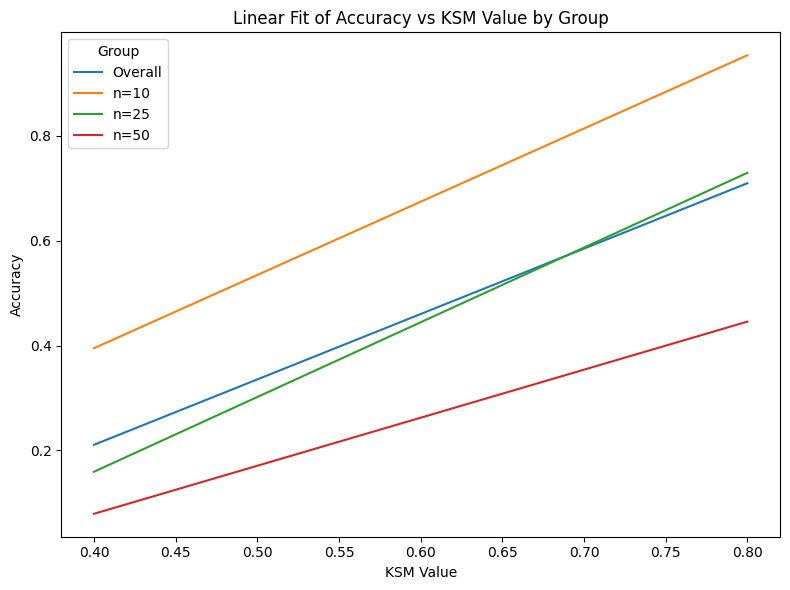

In [122]:

df = (
    all_df
    .dropna(subset=['ksm_value','accuracy'])
    .assign(
        ksm_value=pd.to_numeric(all_df['ksm_value'], errors='coerce'),
        accuracy =pd.to_numeric(all_df['accuracy'],    errors='coerce'),
        graph_size=pd.to_numeric(all_df['graph_size'], errors='coerce')
    )
).dropna(subset=['ksm_value','accuracy','graph_size'])

groups = [('Overall', df)]
for size in [10, 25, 50]:
    groups.append((f'n={size}', df[df['graph_size'] == size]))

x_min, x_max = df['ksm_value'].min(), df['ksm_value'].max()
x_line = np.linspace(x_min, x_max, 100)


plt.figure(figsize=(8, 6))
for label, subdf in groups:
    slope, intercept = np.polyfit(subdf['ksm_value'], subdf['accuracy'], 1)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, label=label)

plt.xlabel('KSM Value')
plt.ylabel('Accuracy')
plt.title('Linear Fit of Accuracy vs KSM Value by Group')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


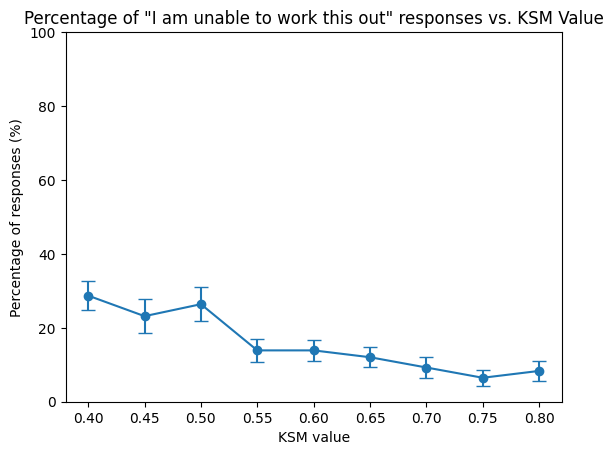

In [123]:

valid = all_df[all_df['parameters_indices'] != 'undefined'].copy()

per_subj_zero = (
    valid
    .groupby(['participantId', 'ksm_value'])['answer']
    .apply(lambda answers: (answers == 0).mean())
    .reset_index(name='p_zero')
)

summary_zero = (
    per_subj_zero
    .groupby('ksm_value')['p_zero']
    .agg(mean='mean', sem=lambda x: x.sem())
    .reset_index()
)


summary_zero['mean_pct'] = summary_zero['mean'] * 100
summary_zero['sem_pct']  = summary_zero['sem']  * 100


plt.figure()
plt.errorbar(
    summary_zero['ksm_value'],
    summary_zero['mean_pct'],
    yerr=summary_zero['sem_pct'],
    marker='o',
    linestyle='-',
    capsize=5
)
plt.xlabel("KSM value")
plt.ylabel("Percentage of responses (%)")
plt.title("Percentage of \"I am unable to work this out\" responses vs. KSM Value")
plt.ylim(0, 100)
plt.show()


In [ ]:
import os

fnames = []
actual_folders = ["n10-1", "n10-2", "n10-3", "n25-1", "n25-2", "n25-3", "n50-1", "n50-2", "n50-3"]

for folder in os.listdir("..\\stress-performance-spl\\SPL_Stimuli"):
    if folder not in actual_folders:
        continue

    for sol in os.listdir(f"..\\stress-performance-spl\\SPL_Stimuli\\{folder}\\Solutions"):
        fnames.append(sol)

print(fnames)

# with open("solution_filenames.txt", "w" ) as f:
#     f.write("\n".join(fnames))

['n10-1A-drawing-0.4-spl3-solution.png', 'n10-1A-drawing-0.45-spl2-solution.png', 'n10-1A-drawing-0.5-spl2-solution.png', 'n10-1A-drawing-0.55-spl3-solution.png', 'n10-1A-drawing-0.6-spl2-solution.png', 'n10-1A-drawing-0.65-spl4-solution.png', 'n10-1A-drawing-0.7-spl3-solution.png', 'n10-1A-drawing-0.75-spl2-solution.png', 'n10-1A-drawing-0.8-spl4-solution.png', 'n10-1B-drawing-0.4-spl3-solution.png', 'n10-1B-drawing-0.45-spl2-solution.png', 'n10-1B-drawing-0.5-spl2-solution.png', 'n10-1B-drawing-0.55-spl3-solution.png', 'n10-1B-drawing-0.6-spl2-solution.png', 'n10-1B-drawing-0.65-spl4-solution.png', 'n10-1B-drawing-0.7-spl3-solution.png', 'n10-1B-drawing-0.75-spl2-solution.png', 'n10-1B-drawing-0.8-spl4-solution.png', 'n10-1C-drawing-0.4-spl3-solution.png', 'n10-1C-drawing-0.45-spl2-solution.png', 'n10-1C-drawing-0.5-spl2-solution.png', 'n10-1C-drawing-0.55-spl3-solution.png', 'n10-1C-drawing-0.6-spl2-solution.png', 'n10-1C-drawing-0.65-spl4-solution.png', 'n10-1C-drawing-0.7-spl3-sol